# AirBnB listings analysis
Guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle and Boston

### Questions
1. What are the key factors that drive the rental price? Also ,do we find any interesting findings?

2. For the same set of key factors, is there is a price difference between cities ?

3. Does review score/number of reviews impact the price or bookings?


- Import libraries
- Read in csv files



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

listings_seattle=pd.read_csv("../airbnbseattle/listings.csv")
reviews_seattle=pd.read_csv("../airbnbseattle/reviews.csv")
calendar_seattle=pd.read_csv("../airbnbseattle/calendar.csv")

listings_boston=pd.read_csv("../airbnbboston/listings.csv")
reviews_boston=pd.read_csv("../airbnbboston/reviews.csv")
calendar_boston=pd.read_csv("../airbnbboston/calendar.csv")
#listings_boston.columns

In [2]:
listings_seattle.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [3]:
dict(listings_seattle.dtypes)

{'id': dtype('int64'),
 'listing_url': dtype('O'),
 'scrape_id': dtype('int64'),
 'last_scraped': dtype('O'),
 'name': dtype('O'),
 'summary': dtype('O'),
 'space': dtype('O'),
 'description': dtype('O'),
 'experiences_offered': dtype('O'),
 'neighborhood_overview': dtype('O'),
 'notes': dtype('O'),
 'transit': dtype('O'),
 'thumbnail_url': dtype('O'),
 'medium_url': dtype('O'),
 'picture_url': dtype('O'),
 'xl_picture_url': dtype('O'),
 'host_id': dtype('int64'),
 'host_url': dtype('O'),
 'host_name': dtype('O'),
 'host_since': dtype('O'),
 'host_location': dtype('O'),
 'host_about': dtype('O'),
 'host_response_time': dtype('O'),
 'host_response_rate': dtype('O'),
 'host_acceptance_rate': dtype('O'),
 'host_is_superhost': dtype('O'),
 'host_thumbnail_url': dtype('O'),
 'host_picture_url': dtype('O'),
 'host_neighbourhood': dtype('O'),
 'host_listings_count': dtype('float64'),
 'host_total_listings_count': dtype('float64'),
 'host_verifications': dtype('O'),
 'host_has_profile_pic': dt

## Preprocessing - Clean and Transform Data
- Identify numerical columns inferred as string
- Clean Data
- Transform Data Type

In [4]:
def get_cols(df,col_name_match):
    '''
    INPUT - df - pandas dataframe 
            col_name_match - string - the name of the column you would like to match using regex
    OUTPUT - 
            matched_cols - Index/list of matched columns
    '''
    col_filter='(?i)(.*'+col_name_match+'.*)'
    matched_cols=df.columns[df.columns.str.contains(col_filter,regex=True)]
    return matched_cols

#listings.filter(regex='(?i)(.*review.*)').dtypes

In [5]:
def change_col_type(df,list_cols,to_type):
    '''
    INPUT - df - pandas dataframe 
            list_cols - list of columns whose data type has to be changed
            to_type - type to type cast to - ex: float 
    OUTPUT - 
            None - in place modified dataframe
    '''
    for col in list(list_cols):
    #df[col]=df[col].apply(lambda x:x[1:].replace(',','')).astype(float)
        df[col]=df[col].str.replace('$','',regex=True)
        df[col]=df[col].str.replace(',','',regex=True)
        df[col]=df[col].astype(to_type)


## Most important features
- We will define correlation cutoffs for those positively and negatively correlated so as to reduce the dimensions 
- We can eliminate descriptive columns which don't add any value for our analysis 
ex: listing_url/thumbail
- **Note**: Correlation between 2 columns automatically discards NaN 

In [6]:
correlation_p_cutoff=0.2
correlation_n_cutoff=-0.2

In [7]:
def get_important_numeric_cols(df,target_col,correlation_p_cutoff,correlation_n_cutoff):
    '''
    INPUT - df - pandas dataframe 
            target_col - column against which correlation is compared against other columns
            correlation_p_cutoff - positive threshold of considering important 
            correlation_n_cutoff - negative threshold of considering important 
    OUTPUT - 
            list- important numeric columns
    '''
    corr_mat=df.corr()
    corr_mat_price=corr_mat[target_col].sort_values(ascending=False)
    #print(corr_mat_price)
    corr_numeric_cols=corr_mat_price.index[(corr_mat_price > correlation_p_cutoff) | (corr_mat_price < correlation_n_cutoff)]
    #print(corr_numeric_cols)
    return corr_numeric_cols
   


In [8]:
def get_important_cat_cols(df,target_col,include_cols,correlation_p_cutoff,correlation_n_cutoff):
    '''
    Constructs Dummy variables for categorical columns
    
    INPUT - df - pandas dataframe 
            target_col - column against which correlation is compared against other columns
            correlation_p_cutoff - positive threshold of considering important 
            correlation_n_cutoff - negative threshold of considering important 
    OUTPUT - 
            list- important numeric columns
    '''
    df=df[include_cols]
    cat_cols=df.columns.tolist().copy()
    cat_cols.remove('id')
    cat_cols.remove(target_col)
    df=pd.get_dummies(df,columns=cat_cols,prefix=cat_cols,prefix_sep='_',dummy_na=True)
    #drop_first=True
    ## I am not dropping first categorical variable, since we can clearly differentiate whats positively correlates the price
    cat_corr_mat=df.corr()
    
    corr_cat_cols=cat_corr_mat[target_col]
    #print(corr_cat_cols.sort_values(ascending=False).head())d
    corr_cat_cols=corr_cat_cols.index[(corr_cat_cols > correlation_p_cutoff) | ((corr_cat_cols < correlation_n_cutoff))]
    #print("---")
    #print(corr_cat_cols)
    return (corr_cat_cols,df)

## Analyze city process
- With all the preprocessing functions defined, we can finally transform categorical columns and combine with numerical columns to analyse and derive insights 
- We will use pivot table and heatmap to visualize our results

- We can get rid of weekly and monthly price columns as they are highly correlated to daily price .beds and bedrooms are closely correlated(shown in the github code) which are redundant and one of them can be retained). In technical terms we are removing collinearity

In [9]:
def analyze_city(df,include_cols):
    '''
    gets the most import numeric and categorical columns and does a combined correlation analsyis
    
    INPUT - df - pandas dataframe 
            include_cols- list of categorical columns to consider
    OUTPUT - 
            pivot table over most important columns on avg_price
    '''
    corr_numeric_cols=get_important_numeric_cols(df,'price',correlation_p_cutoff,correlation_n_cutoff)
    corr_numeric_cols=corr_numeric_cols.drop(['weekly_price', 'monthly_price'])
    #print(corr_numeric_cols)   
    numeric_cols=['id'] 
    numeric_cols.extend(corr_numeric_cols)
    df_numeric=df[numeric_cols]
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(df_numeric.corr(),annot=True,ax=ax);
    
    #dict(df.select_dtypes(include=['object']).nunique().sort_values(ascending=True))
    
    corr_cat_cols,df_cat=get_important_cat_cols(df,'price',include_cols,correlation_p_cutoff,correlation_n_cutoff)
    
    cat_imp_cols=['id'] 
    cat_imp_cols.extend(corr_cat_cols)
    df_cat=df_cat[cat_imp_cols]
    fig, ax = plt.subplots(figsize=(20,20)) 
    sns.heatmap(df_cat.corr(),annot=True,ax=ax);
    
    df_price_factors=df_numeric.merge(df_cat,on=['id','price'])
    
    ig, ax = plt.subplots(figsize=(20,20)) 
    sns.heatmap(df_price_factors.corr(),annot=True,ax=ax);
    
    #df_price_factors=df_price_factors.rename(columns={'room_type_Entire home/apt':'Entire Home','room_type_Private room':'Private room'})
    all_except_price_cols=df_price_factors.columns.tolist()
    all_except_price_cols.remove('price')
    all_except_price_cols.remove('id')
    print(all_except_price_cols)
    return df_price_factors.pivot_table(index=all_except_price_cols,values=['price'],aggfunc=np.mean).sort_values('price',ascending=False).rename(columns={'price':'avg_price'})

## Prepare and analyze each city's data separately and together 

In [10]:
price_cols=get_cols(listings_seattle,'price')
review_cols=get_cols(listings_seattle,'review')
change_col_type(listings_seattle,price_cols,float)

print(price_cols)
#print(review_cols)
print(listings_seattle[price_cols].head(5))
print()
#print(listings_seattle[price_cols].dtypes)
#print()
#print(listings_seattle[review_cols].head(5))
#print()
#print(listings_seattle[review_cols].dtypes)

Index(['price', 'weekly_price', 'monthly_price'], dtype='object')
   price  weekly_price  monthly_price
0   85.0           NaN            NaN
1  150.0        1000.0         3000.0
2  975.0           NaN            NaN
3  100.0         650.0         2300.0
4  450.0           NaN            NaN



C:\Users\advitha\miniconda3\envs\deep-learning\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


['accommodates', 'bedrooms', 'beds', 'square_feet', 'bathrooms', 'guests_included', 'reviews_per_month', 'room_type_Entire home/apt', 'room_type_Private room', 'cancellation_policy_strict']


avg_price
accommodates bedrooms beds square_feet bathrooms guests_included reviews_per_month room_type_Entire home/apt room_type_Private room cancellation_policy_strict           
16           6.0      9.0  2600.0      2.0       13              0.48              1                         0                      1                               673.0
9            4.0      5.0  3000.0      3.0       9               0.04              1                         0                      1                               395.0
8            5.0      1.0  3000.0      2.5       8               0.09              1                         0                      1                               370.0
10           3.0      5.0  1850.0      2.0       8               0.67              1                         0                      1                               360.0
8            2.0      3.0  1200.0      2.0       2               0.81              1                         0                      1                               325.0
...                                                                                                                                                                   ...
2            1.0      1.0  2000.0      1.5       1               0.90              0                         1                      0                                60.0
                           140.0       1.5       1               0.77              0                         1                      0                                60.0
1            1.0      1.0  1300.0      1.0       1               0.06              0                         1                      0                                55.0
2            1.0      1.0  250.0       1.0       2               0.27              0                         1                      0                                54.0
                           2000.0      1.5       1               0.85              0                         1                      0                                40.0

[88 rows x 1 columns]

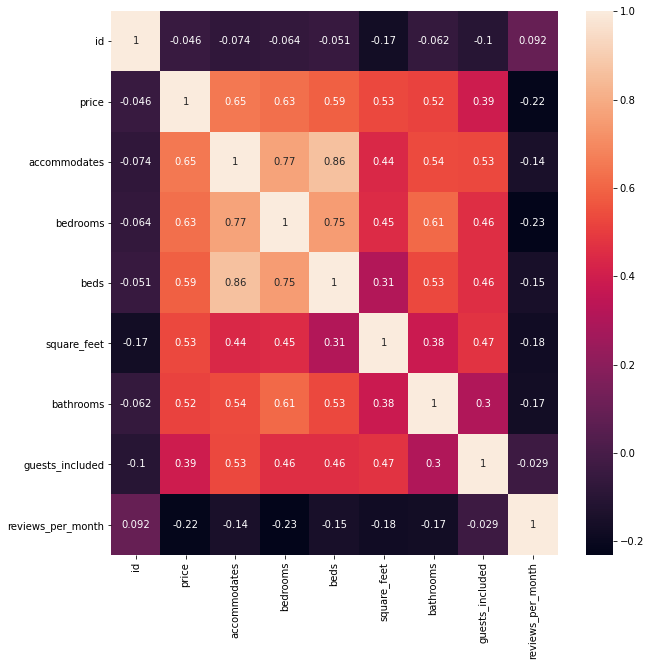

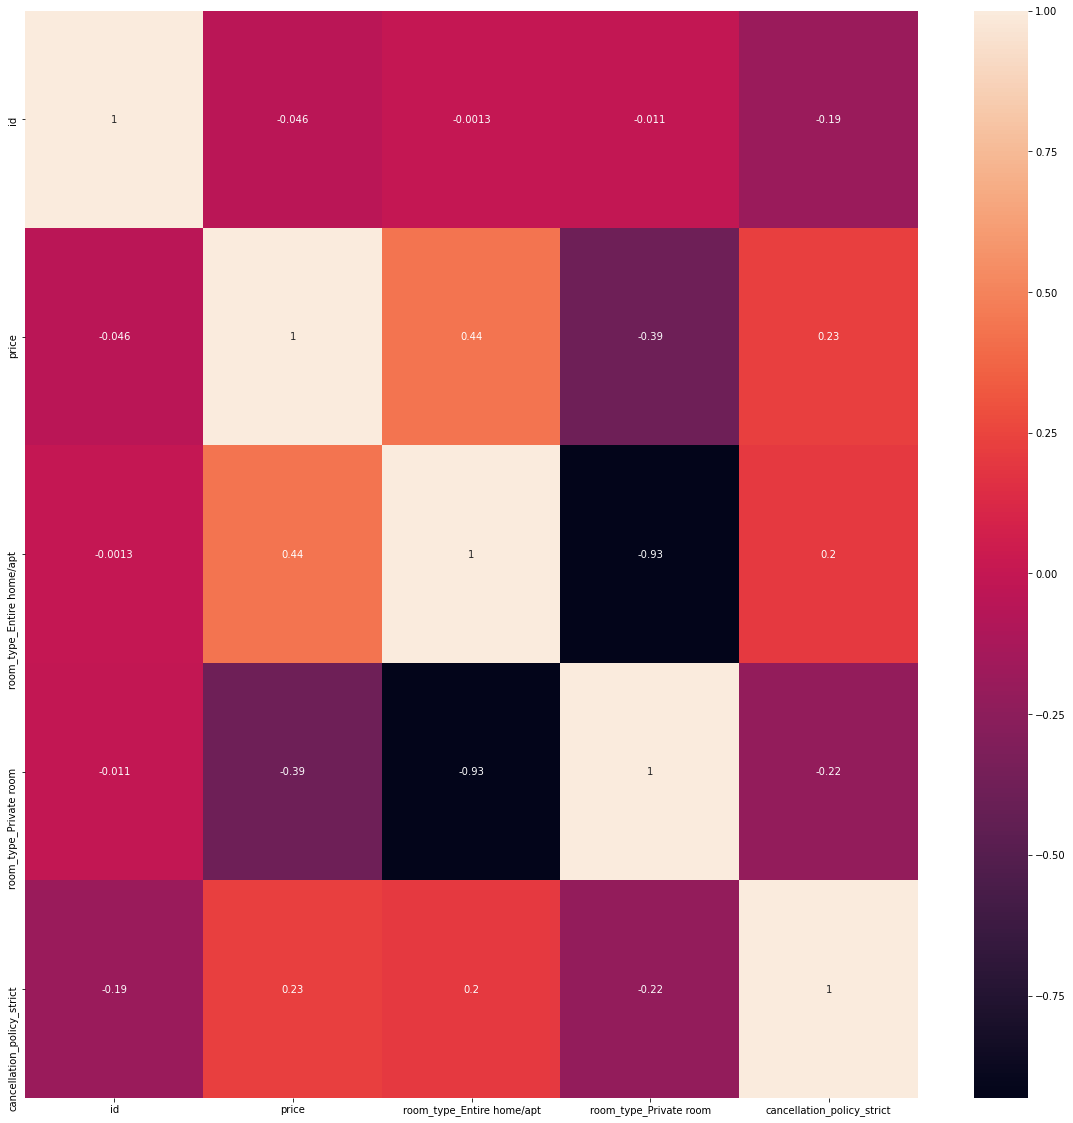

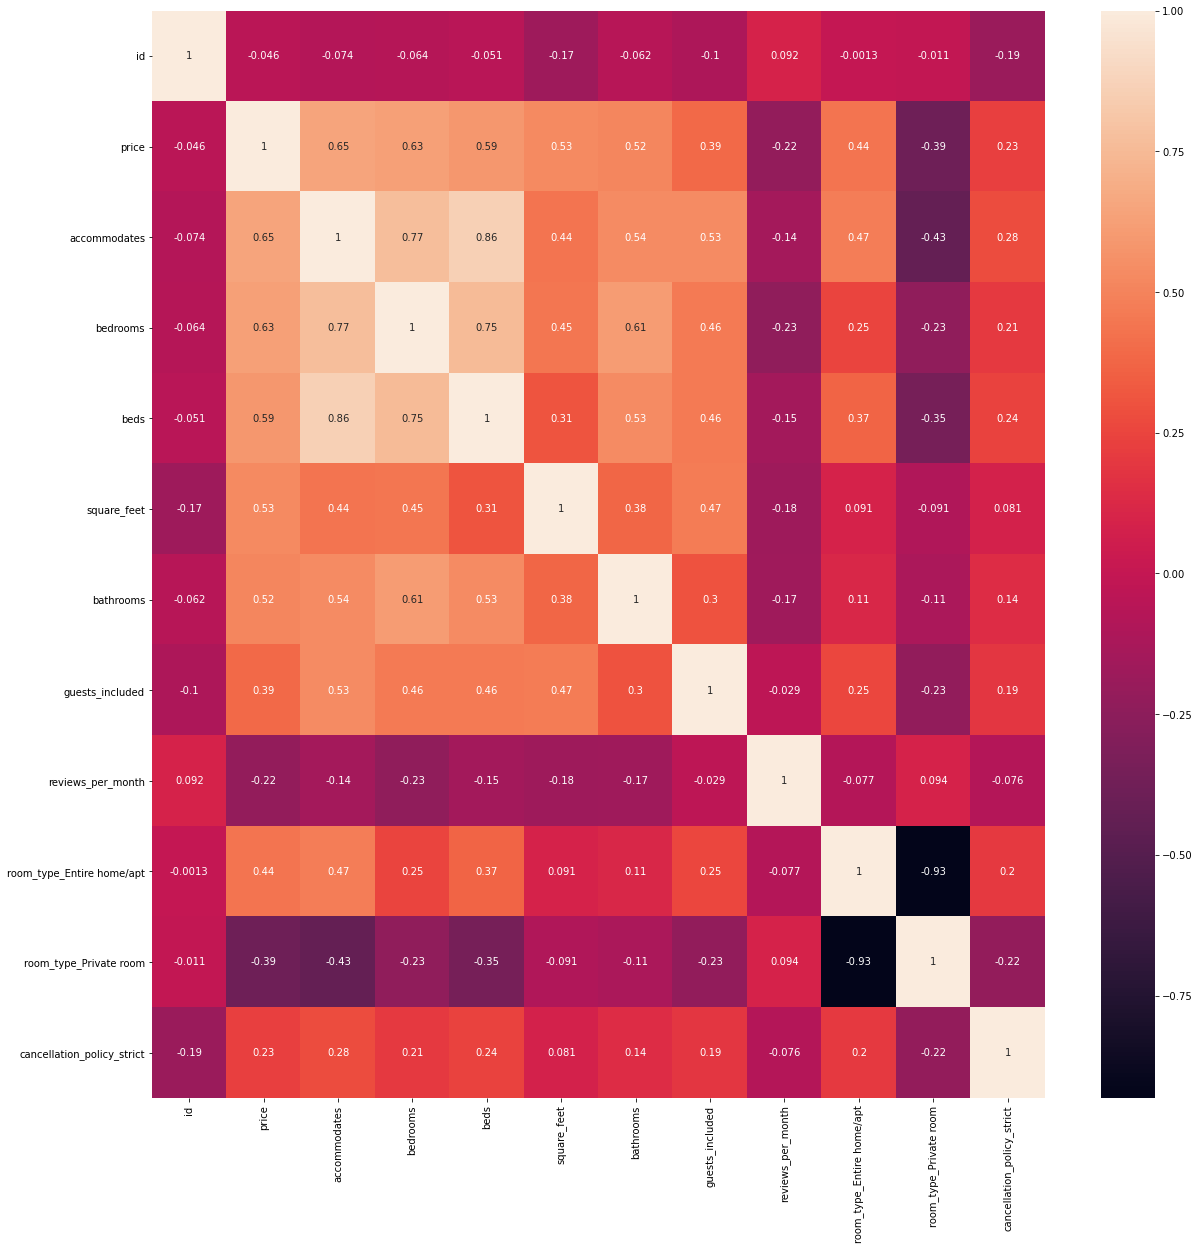

In [11]:
include_cols=['id','price','room_type','city','zipcode','state','smart_location','bed_type','instant_bookable','cancellation_policy']
analyze_city(listings_seattle,include_cols)

In [12]:
price_cols=get_cols(listings_boston,'price')
review_cols=get_cols(listings_boston,'review')
change_col_type(listings_boston,price_cols,float)

listings_boston[price_cols].dtypes
print(price_cols)
print(review_cols)

Index(['price', 'weekly_price', 'monthly_price'], dtype='object')
Index(['number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')


C:\Users\advitha\miniconda3\envs\deep-learning\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


['square_feet', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'guests_included', 'room_type_Entire home/apt', 'room_type_Private room']


,,,,,,,,avg_price
square_feet,accommodates,bedrooms,beds,bathrooms,guests_included,room_type_Entire home/apt,room_type_Private room,
2000.0,12,4.0,5.0,2.0,1,1,0,725.0
2300.0,12,4.0,1.0,1.0,1,1,0,525.0
2000.0,5,2.0,4.0,2.5,4,1,0,500.0
850.0,6,2.0,2.0,1.0,1,1,0,449.0
2.0,11,5.0,6.0,1.5,8,1,0,400.0
1050.0,2,1.0,1.0,1.0,1,1,0,359.0
900.0,4,2.0,2.0,1.0,6,1,0,342.0
1200.0,8,3.0,3.0,1.0,4,1,0,334.0
850.0,4,2.0,2.0,1.0,4,1,0,320.0


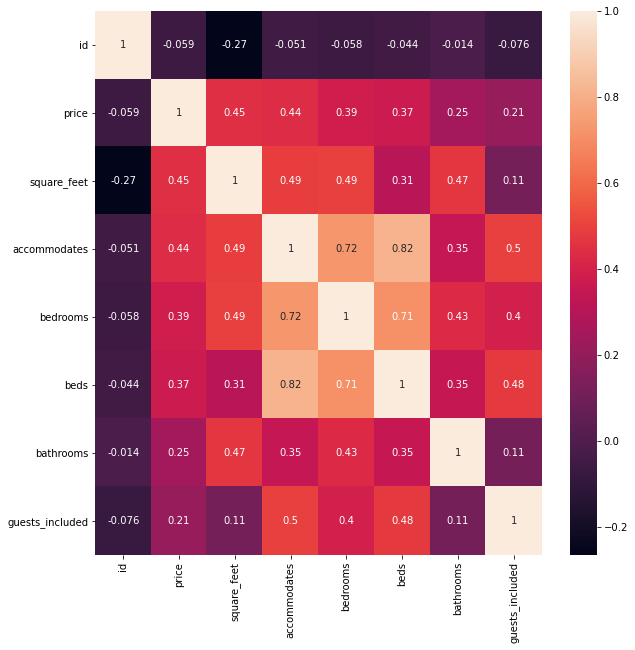

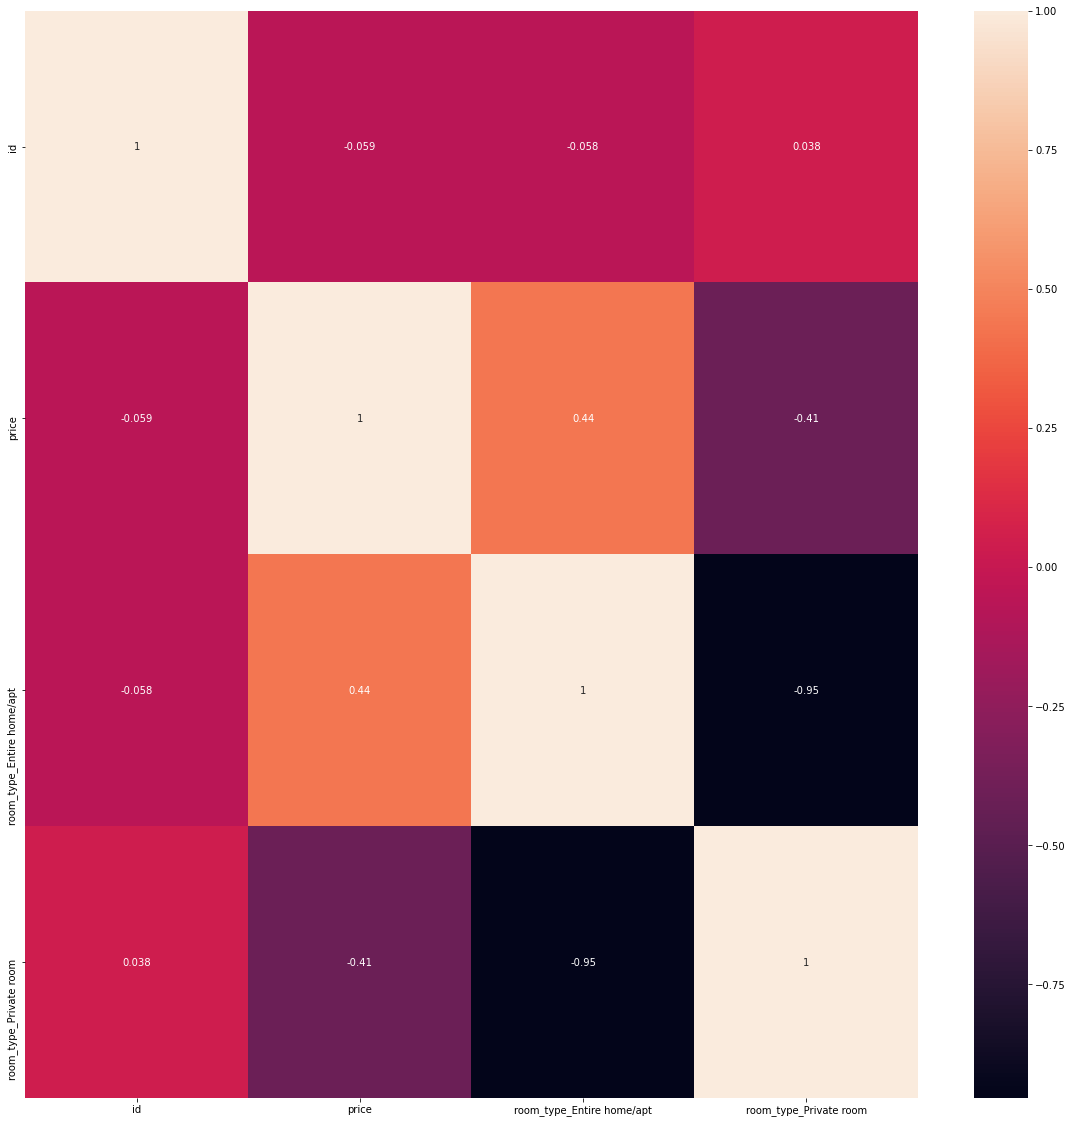

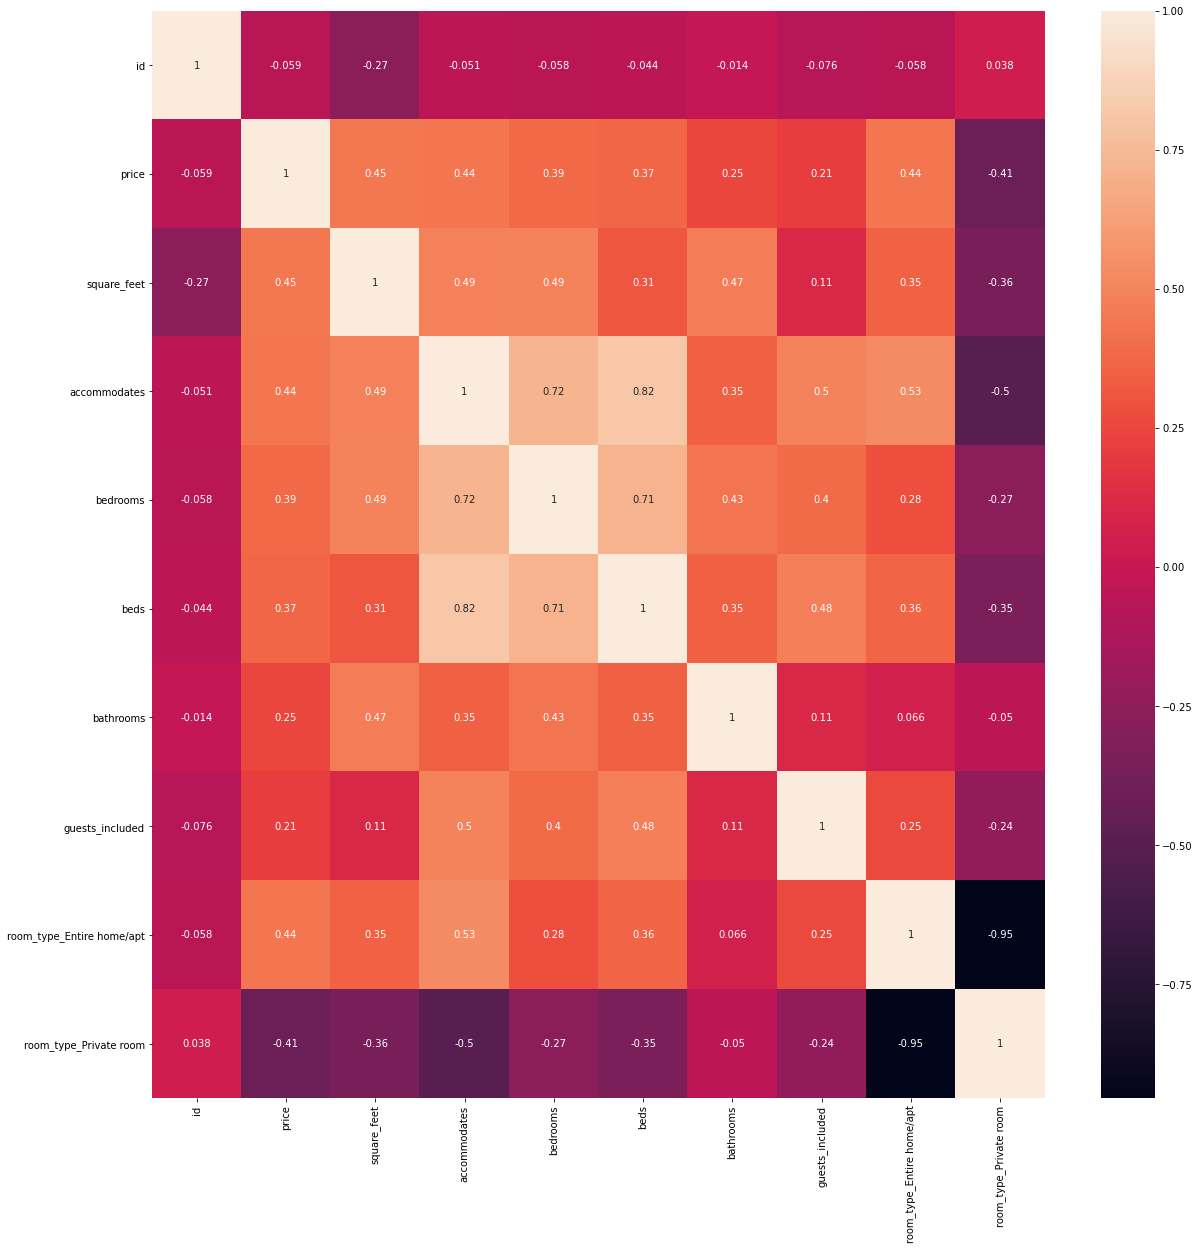

In [13]:
analyze_city(listings_boston,include_cols)

['accommodates', 'square_feet', 'bedrooms', 'beds', 'bathrooms', 'guests_included', 'room_type_Entire home/apt', 'room_type_Private room']


,,,,,,,,avg_price
accommodates,square_feet,bedrooms,beds,bathrooms,guests_included,room_type_Entire home/apt,room_type_Private room,
12,2000.0,4.0,5.0,2.0,1,1,0,725.0
16,2600.0,6.0,9.0,2.0,13,1,0,673.0
12,2300.0,4.0,1.0,1.0,1,1,0,525.0
5,2000.0,2.0,4.0,2.5,4,1,0,500.0
6,850.0,2.0,2.0,1.0,1,1,0,449.0
...,...,...,...,...,...,...,...,...
2,1000.0,1.0,1.0,1.0,1,0,1,55.0
1,1300.0,1.0,1.0,1.0,1,0,1,55.0
2,250.0,1.0,1.0,1.0,2,0,1,54.0


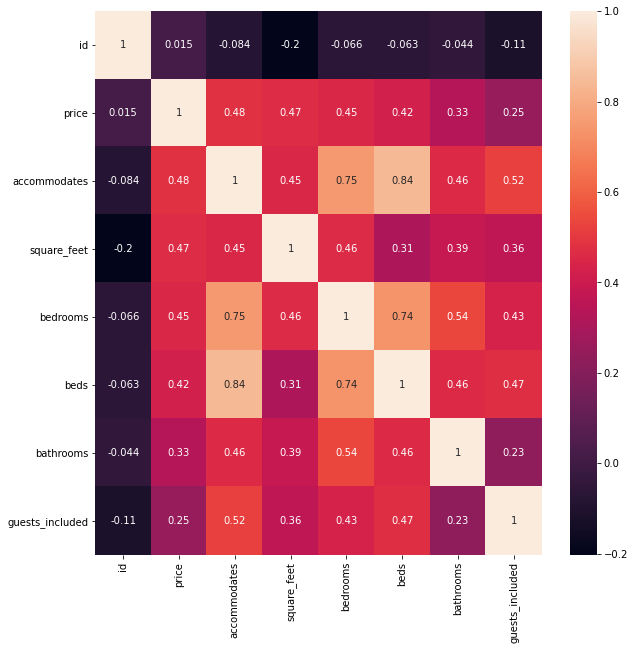

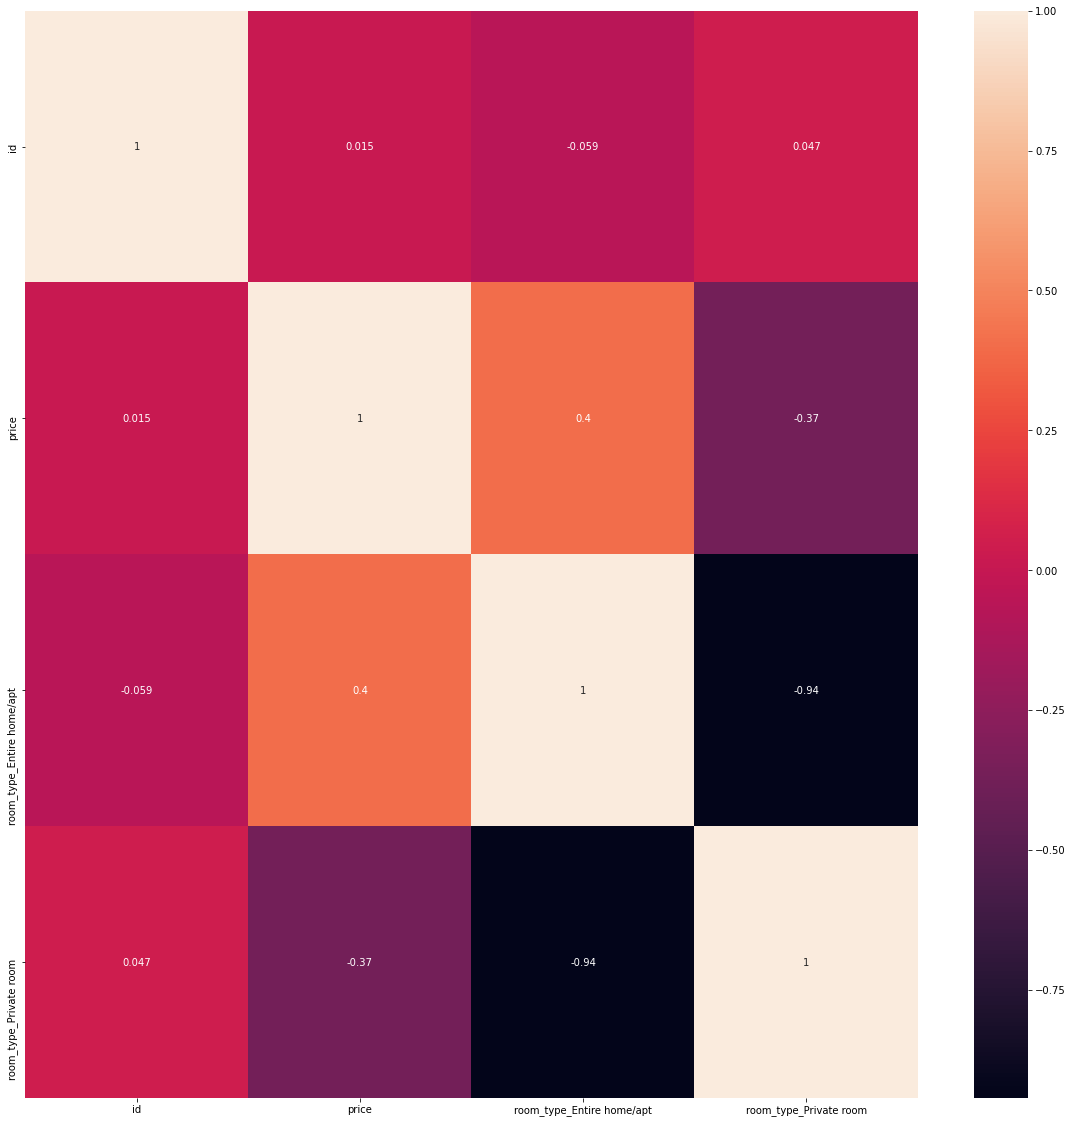

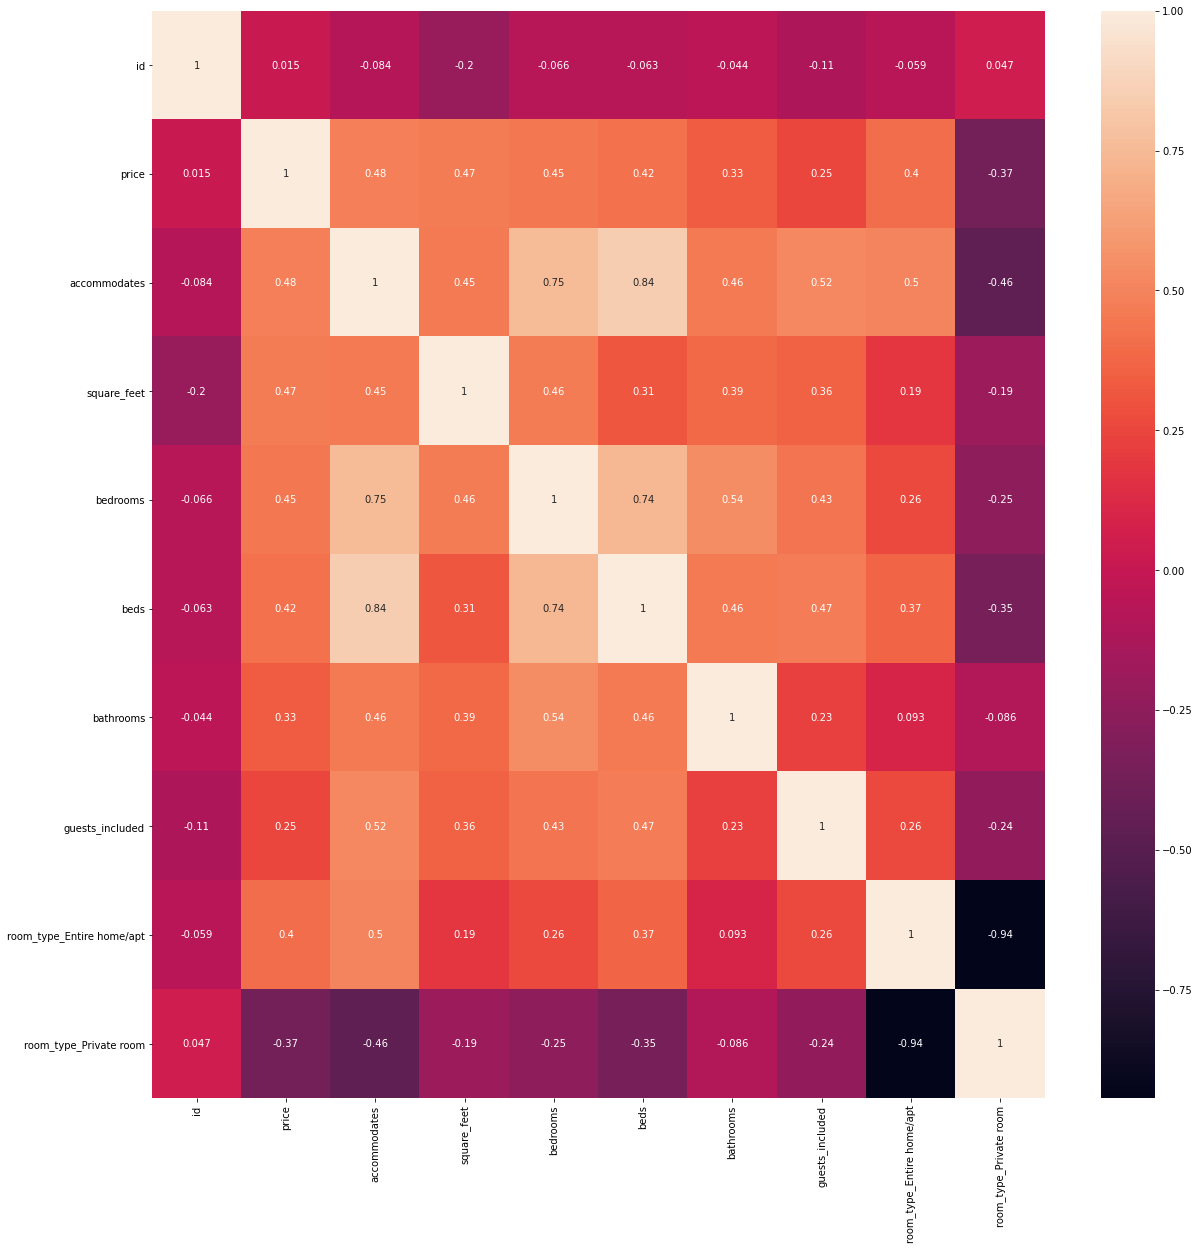

In [14]:
listings_both=pd.concat([listings_seattle,listings_boston],axis=0)


analyze_city(listings_both,include_cols)


## Comparison of price differences between cities
- Let's narrow down to the most important column for grouping , reorder columns and use bar chart to visualize the stylized bar char

In [15]:
print(listings_boston['price'].mean())
print(listings_seattle['price'].mean())
#group_cols=['accommodates','bedrooms','square_feet']
group_cols=['accommodates']
B=listings_boston.groupby(group_cols)[['price']].mean().sort_values('price',ascending=False)
A=listings_seattle.groupby(group_cols)[['price']].mean().sort_values('price',ascending=False)

boston_vs_seattle=pd.merge(A,B,on=group_cols,how='outer',suffixes=('_seattle','_boston'))

pd.set_option('display.max_rows',None)
boston_vs_seattle['Difference']=  boston_vs_seattle['price_boston'] - boston_vs_seattle['price_seattle']

boston_vs_seattle=boston_vs_seattle[[boston_vs_seattle.columns[0],boston_vs_seattle.columns[2],boston_vs_seattle.columns[1]]]
boston_vs_seattle.style.bar(subset=['Difference'],align='mid',color=['red','green'])


173.9258019525802
127.97616553169199


,price_seattle,Difference,price_boston
accommodates,,,
11,566.666667,-209.166667,357.500000
16,439.750000,-277.250000,162.500000
9,396.153846,-45.053846,351.100000
14,381.333333,28.666667,410.000000
10,362.640000,7.833684,370.473684
12,345.666667,160.133333,505.800000
8,295.478992,53.102827,348.581818
15,286.000000,nan,nan
7,220.788462,103.032051,323.820513


# Questions and  Conclusion

- What are the key factors that drive the rental price? Also ,do we find any interesting findings?

    Usually lease/tenant accommodations, the square_feet of the property is a good indicator of price but for holiday/guest hosting, the size of the property is not the most important driving factor. We see listings where 3000 square_feet properties are comparitively priced less.
'accommodates', 'bedrooms', 'beds', 'square_feet', 'bathrooms', 'guests_included', 'room_type_Entire home/apt', 'room_type_Private room', 'cancellation_policy_strict'

- For the same set of key factors, is there is a price difference between cities ?

    Yes on average, the Boston city yields 50$ more rental prices compared to Seattle city . There are exceptions for higher values of 'accommodates' 

- Does review score/number of reviews impact the price or bookings?

    Average review score has no/very less relationship with price. Well !It makes sense that reviews don't drive the price :-), rather they might impact the number of bookings(which can be analyzed with bookings data set )
If you had observed 'reviews_per_month' - the more the number of reviews the less the price of the property . Well it might NOT be a causal relationship. Rather guests who had negative experiences tend to give more reviews than people with positive/neutral experiences.

https://aravind-deva.medium.com/what-drives-the-rental-price-of-homes-and-rooms-for-guest-accommodation-496d7726d20


















# MISCELLAENOUS

In [16]:
#listings['host_response_rate']=listings['host_response_rate'].str.replace('%','').astype('float')
#listings['host_acceptance_rate']=listings['host_acceptance_rate'].str.replace('%','').astype('float')


In [17]:
dict(listings_seattle.select_dtypes(include=['object']).nunique().sort_values(ascending=True))

{'country': 1,
 'last_scraped': 1,
 'market': 1,
 'jurisdiction_names': 1,
 'requires_license': 1,
 'experiences_offered': 1,
 'calendar_last_scraped': 1,
 'has_availability': 1,
 'country_code': 1,
 'state': 2,
 'require_guest_profile_picture': 2,
 'host_identity_verified': 2,
 'host_has_profile_pic': 2,
 'is_location_exact': 2,
 'host_is_superhost': 2,
 'host_acceptance_rate': 2,
 'require_guest_phone_verification': 2,
 'instant_bookable': 2,
 'room_type': 3,
 'cancellation_policy': 3,
 'host_response_time': 4,
 'bed_type': 5,
 'city': 7,
 'smart_location': 7,
 'property_type': 16,
 'neighbourhood_group_cleansed': 17,
 'zipcode': 28,
 'calendar_updated': 34,
 'extra_people': 45,
 'host_response_rate': 45,
 'security_deposit': 46,
 'neighbourhood': 81,
 'neighbourhood_cleansed': 87,
 'host_neighbourhood': 102,
 'host_verifications': 116,
 'cleaning_fee': 118,
 'host_location': 120,
 'last_review': 321,
 'first_review': 984,
 'host_since': 1380,
 'street': 1442,
 'host_name': 1466,
 'n

In [18]:
print(listings_seattle['room_type'].unique())
print(listings_seattle['city'].unique())
print(listings_seattle['zipcode'].unique())
print(listings_seattle['state'].unique())
print(listings_seattle['smart_location'].unique())
print(listings_seattle['bed_type'].unique())
print(listings_seattle['instant_bookable'].unique())
print(listings_seattle['cancellation_policy'].unique())
print(listings_seattle['amenities'].unique())

['Entire home/apt' 'Private room' 'Shared room']
['Seattle' 'Ballard, Seattle' 'West Seattle' 'Seattle ' '西雅图'
 'Phinney Ridge Seattle' 'seattle']
['98119' '98109' '98107' '98117' nan '98103' '98105' '98115' '98101'
 '98122' '98112' '98144' '99\n98122' '98121' '98102' '98199' '98104'
 '98134' '98136' '98126' '98146' '98116' '98177' '98118' '98108' '98133'
 '98106' '98178' '98125']
['WA' 'wa']
['Seattle, WA' 'Ballard, Seattle, WA' 'West Seattle, WA' 'Seattle , WA'
 '西雅图, WA' 'Phinney Ridge Seattle, WA' 'seattle, wa']
['Real Bed' 'Futon' 'Pull-out Sofa' 'Airbed' 'Couch']
['f' 't']
['moderate' 'strict' 'flexible']
['{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}'
 '{TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}'
 '{TV,"Cable TV"

In [19]:
listings_seattle[['bedrooms','beds']].corr()

,bedrooms,beds
bedrooms,1.000000,0.753167
beds,0.753167,1.000000
